In [1]:
import pandas_datareader as pdr

In [2]:
df = pdr.get_data_tiingo('AAPL',api_key= 'c98d2a703f1f821f09e035b6e140f0a48f7571d9' )

In [3]:
df.to_csv('apple.csv')

In [4]:
import pandas as pd

In [5]:
data = pd.read_csv('apple.csv')

In [6]:
data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-11-27 00:00:00+00:00,117.81,118.41,117.60,118.29,13046445,27.283451,27.422404,27.234817,27.394613,52185780,0.0,1.0
1,AAPL,2015-11-30 00:00:00+00:00,118.30,119.41,117.75,117.99,39180322,27.396929,27.653993,27.269555,27.325137,156721288,0.0,1.0
2,AAPL,2015-12-01 00:00:00+00:00,117.34,118.81,116.86,118.75,34852374,27.174604,27.515039,27.063442,27.501144,139409496,0.0,1.0
3,AAPL,2015-12-02 00:00:00+00:00,116.28,118.11,116.08,117.05,33386563,26.929120,27.352927,26.882803,27.107443,133546252,0.0,1.0
4,AAPL,2015-12-03 00:00:00+00:00,115.20,116.79,114.22,116.55,41569509,26.679005,27.047230,26.452048,26.991649,166278036,0.0,1.0


In [7]:
data.shape

(1257, 14)

In [8]:
df = data.reset_index()['close']

In [9]:
df


0       117.81
1       118.30
2       117.34
3       116.28
4       115.20
         ...  
1252    119.39
1253    118.03
1254    118.64
1255    117.34
1256    113.85
Name: close, Length: 1257, dtype: float64

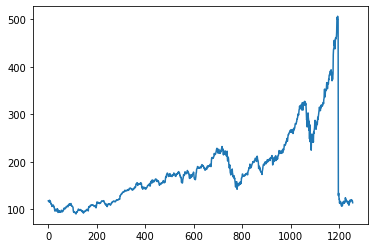

In [10]:
import matplotlib.pyplot as plt
plt.plot(df)

In [11]:
#to Normalize the data using the minmaxscaler

In [12]:
import numpy as np

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))

In [15]:
df = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [16]:
print(df)

[[0.06607336]
 [0.06725195]
 [0.06494287]
 ...
 [0.06806975]
 [0.06494287]
 [0.05654841]]


In [17]:
len(df)

1257

In [18]:
#Splitting into training into training and test dataset of a time series data since the data is dependent on the previous days data
training_size = int(len(df)*0.65)
test_size = len(df)- training_size

In [19]:
train_data,test_data = df[0:training_size,:],df[training_size:len(df),:1]

In [20]:
training_size,test_size

(817, 440)

In [21]:
len(train_data)

817

In [32]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [33]:
#reshape X into t,t+1..... and y=t+4
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [34]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [35]:
print(X_train)

[[0.06607336 0.06725195 0.06494287 ... 0.03985568 0.04038485 0.03759471]
 [0.06725195 0.06494287 0.06239327 ... 0.04038485 0.03759471 0.03689717]
 [0.06494287 0.06239327 0.05979555 ... 0.03759471 0.03689717 0.035454  ]
 ...
 [0.32377631 0.32567649 0.32933253 ... 0.19384245 0.19648827 0.19415514]
 [0.32567649 0.32933253 0.33419122 ... 0.19648827 0.19415514 0.19874925]
 [0.32933253 0.33419122 0.34090198 ... 0.19415514 0.19874925 0.20177992]]


In [36]:
print(X_test.shape),print(y_test.shape)

(339, 100)
(339,)


(None, None)

In [37]:
# before using the lstm we have to reshape the x_train and x_test to the 3 dimension
# reshape input be like samples,time_steps,features
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1],1)

In [38]:
# Creating the Stacked Lstm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [40]:
model=Sequential()
model.add(LSTM(50,return_sequences = True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer ='adam')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs =100,batch_size=64,verbose=1)

Train on 716 samples, validate on 339 samples
Epoch 1/100
716/716 [==============================] - 8s 11ms/sample - loss: 0.0054 - val_loss: 0.0458
Epoch 2/100
716/716 [==============================] - 2s 3ms/sample - loss: 0.0013 - val_loss: 0.0232
Epoch 3/100
716/716 [==============================] - 3s 4ms/sample - loss: 6.3407e-04 - val_loss: 0.0193
Epoch 4/100
716/716 [==============================] - 3s 4ms/sample - loss: 4.3189e-04 - val_loss: 0.0188
Epoch 5/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.6046e-04 - val_loss: 0.0185
Epoch 6/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.2383e-04 - val_loss: 0.0182
Epoch 7/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.1139e-04 - val_loss: 0.0180
Epoch 8/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.1240e-04 - val_loss: 0.0173
Epoch 9/100
716/716 [==============================] - 3s 4ms/sample - loss: 3.1203e-04 - val_loss: 0.016

716/716 [==============================] - 2s 3ms/sample - loss: 1.3777e-04 - val_loss: 0.0107
Epoch 77/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.3230e-04 - val_loss: 0.0106
Epoch 78/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.2255e-04 - val_loss: 0.0119
Epoch 79/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.3947e-04 - val_loss: 0.0098
Epoch 80/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.3285e-04 - val_loss: 0.0112
Epoch 81/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.2621e-04 - val_loss: 0.0113
Epoch 82/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.2059e-04 - val_loss: 0.0098
Epoch 83/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.1778e-04 - val_loss: 0.0100
Epoch 84/100
716/716 [==============================] - 2s 3ms/sample - loss: 1.2757e-04 - val_loss: 0.0109
Epoch 85/100
716/716 [===================

In [71]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [72]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [73]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))# train_data RMSE

158.276293272131

In [74]:
#Test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

271.4369917392569

In [75]:
# shift train predictions for plotting
time_step=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

In [76]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(df)-1, :] = test_predict

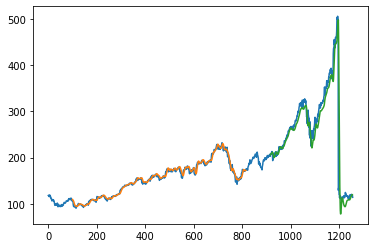

In [77]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [78]:
len(test_data)

440

In [79]:
x_input = test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [80]:
temp_input = list(x_input)

In [81]:
temp_input = temp_input[0].tolist()

In [82]:
temp_input

[0.6819242333132893,
 0.6791340950090199,
 0.7000120264582081,
 0.7039567047504509,
 0.7055682501503309,
 0.7013108839446784,
 0.7165123271196634,
 0.7229344558027659,
 0.7113650030066145,
 0.7094888755261575,
 0.7290198436560433,
 0.7159591100420926,
 0.7185808779314491,
 0.6759831629585087,
 0.673770294648226,
 0.6948887552615755,
 0.6799037883343355,
 0.6971016235718581,
 0.7081659651232712,
 0.8050511124473845,
 0.830811785929044,
 0.8378111846061336,
 0.841635598316296,
 0.8785808779314492,
 0.8517378232110644,
 0.8672760072158752,
 0.8350210463018641,
 0.8699939867708961,
 0.8892363199037885,
 0.8882501503307276,
 0.8853638003607938,
 0.89455201443175,
 0.8959470835838845,
 0.9206494287432352,
 0.9792904389657247,
 0.9936019242333134,
 0.9836680697534577,
 1.0,
 0.9854479855682503,
 0.983499699338545,
 0.09308478653036678,
 0.10544798556825014,
 0.09876127480457003,
 0.07345760673481655,
 0.07365003006614551,
 0.05407095610342749,
 0.06489476849067943,
 0.055682501503307225,
 0.0

In [83]:
# demonstrate prediction for next 40 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.06845586]
101
1 day input [0.6791341  0.70001203 0.7039567  0.70556825 0.70131088 0.71651233
 0.72293446 0.711365   0.70948888 0.72901984 0.71595911 0.71858088
 0.67598316 0.67377029 0.69488876 0.67990379 0.69710162 0.70816597
 0.80505111 0.83081179 0.83781118 0.8416356  0.87858088 0.85173782
 0.86727601 0.83502105 0.86999399 0.88923632 0.88825015 0.8853638
 0.89455201 0.89594708 0.92064943 0.97929044 0.99360192 0.98366807
 1.         0.98544799 0.9834997  0.09308479 0.10544799 0.09876127
 0.07345761 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862
 0.06016837 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046
 0.05164161 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568
 0.06126278 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692
 0.05924233 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871
 0.06898376 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107
 0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
 0.04834636 0.05919423 0.06900782 0

8 day output [[0.06683931]]
9 day input [0.70948888 0.72901984 0.71595911 0.71858088 0.67598316 0.67377029
 0.69488876 0.67990379 0.69710162 0.70816597 0.80505111 0.83081179
 0.83781118 0.8416356  0.87858088 0.85173782 0.86727601 0.83502105
 0.86999399 0.88923632 0.88825015 0.8853638  0.89455201 0.89594708
 0.92064943 0.97929044 0.99360192 0.98366807 1.         0.98544799
 0.9834997  0.09308479 0.10544799 0.09876127 0.07345761 0.07365003
 0.05407096 0.06489477 0.0556825  0.05209862 0.06016837 0.06061335
 0.0524113  0.04810583 0.03968731 0.04748046 0.05164161 0.04036079
 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278 0.06361996
 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233 0.06405292
 0.08192423 0.07398677 0.07420325 0.07304871 0.06898376 0.06167168
 0.06535177 0.06381239 0.06111846 0.0594107  0.05943476 0.06316296
 0.05017438 0.06008419 0.044546   0.04432952 0.04834636 0.05919423
 0.06900782 0.06819002 0.06248948 0.06164762 0.07011425 0.06944077
 0.06956103 0.07206254

18 day output [[0.0723564]]
19 day input [0.80505111 0.83081179 0.83781118 0.8416356  0.87858088 0.85173782
 0.86727601 0.83502105 0.86999399 0.88923632 0.88825015 0.8853638
 0.89455201 0.89594708 0.92064943 0.97929044 0.99360192 0.98366807
 1.         0.98544799 0.9834997  0.09308479 0.10544799 0.09876127
 0.07345761 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862
 0.06016837 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046
 0.05164161 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568
 0.06126278 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692
 0.05924233 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871
 0.06898376 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107
 0.05943476 0.06316296 0.05017438 0.06008419 0.044546   0.04432952
 0.04834636 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762
 0.07011425 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253
 0.06806975 0.06494287 0.05654841 0.06845586 0.06715298 0.06621434
 0.06570967 0.06557036 

26 day output [[0.07639447]]
27 day input [0.86999399 0.88923632 0.88825015 0.8853638  0.89455201 0.89594708
 0.92064943 0.97929044 0.99360192 0.98366807 1.         0.98544799
 0.9834997  0.09308479 0.10544799 0.09876127 0.07345761 0.07365003
 0.05407096 0.06489477 0.0556825  0.05209862 0.06016837 0.06061335
 0.0524113  0.04810583 0.03968731 0.04748046 0.05164161 0.04036079
 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278 0.06361996
 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233 0.06405292
 0.08192423 0.07398677 0.07420325 0.07304871 0.06898376 0.06167168
 0.06535177 0.06381239 0.06111846 0.0594107  0.05943476 0.06316296
 0.05017438 0.06008419 0.044546   0.04432952 0.04834636 0.05919423
 0.06900782 0.06819002 0.06248948 0.06164762 0.07011425 0.06944077
 0.06956103 0.07206254 0.06987372 0.06660253 0.06806975 0.06494287
 0.05654841 0.06845586 0.06715298 0.06621434 0.06570967 0.06557036
 0.06569237 0.06598373 0.06637955 0.06683931 0.06733978 0.06786809
 0.06841634 0.068977

In [90]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [85]:
len(df)

1257

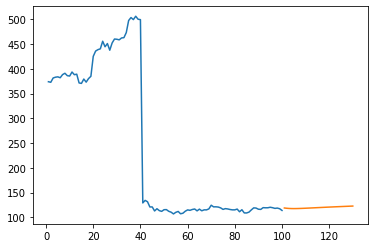

In [91]:
plt.plot(day_new,scaler.inverse_transform(df[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

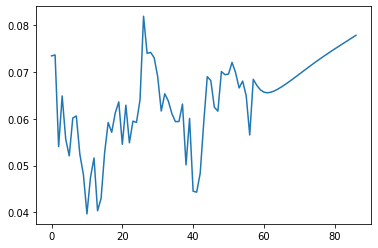

In [92]:
df1=df.tolist()
df1.extend(lst_output)
plt.plot(df1[1200:])

In [93]:
df1=scaler.inverse_transform(df1).tolist()